In [1]:
import os, re, sys, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, AdamW, Nadam, Adamax, SGD, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Normalization, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

Python version: 3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:14:51) [GCC 14.3.0]
TensorFlow version: 2.20.0
Available GPUs: []


In [2]:
SEED = 34


os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ERROR_MARGIN_G = 2

BATCH_SIZE=256
MAX_TRIALS=50
EPOCHS=50

In [3]:
df = pd.DataFrame(pd.read_csv('3d_print_miniatures_base.csv'))

In [4]:
df.describe()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
count,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,1.288800e+04,12888.000000,12888.000000,12888.000000,12887.000000,11602.000000
mean,0.757837,1210.681642,39134.951852,14555.546906,31609.097182,43.593562,34.885004,50.215750,1.482449e+05,14555.546906,4366.614215,76.762979,14.498485,57.721944
std,0.749289,666.207804,41068.365122,22317.718749,46584.665163,27.860584,20.960410,29.334768,5.993805e+05,22317.718749,18333.158356,42.690615,23.691328,41.094890
min,0.000000,0.000000,727.132812,-383.257131,39.938355,3.540864,2.777933,2.887104,3.917259e+01,-383.257131,-126586.000000,6.317293,0.014785,15.000000
25%,0.000000,627.000000,6452.596680,1711.129269,5156.569357,24.325485,20.660660,28.295200,1.531937e+04,1711.129269,505.000000,46.302266,1.527586,30.000000
50%,1.000000,1232.000000,27246.712891,5349.788956,13512.230290,35.004646,30.806185,43.407283,4.590776e+04,5349.788956,1380.000000,66.435881,5.063407,50.000000
75%,1.000000,1792.000000,54880.794922,17298.943933,35962.199213,56.913000,46.611198,65.035666,1.463975e+05,17298.943933,3663.250000,98.369377,17.061743,75.000000
max,2.000000,2343.000000,429450.863281,314692.280269,484544.629610,223.300697,1173.446252,513.482544,6.136918e+07,314692.280269,737690.000000,1284.917846,693.495100,420.000000


In [5]:
df.head()

,artist,mini,kb,volume,surface_area,bbox_x,bbox_y,bbox_z,bbox_area,mass,euler_number,scale,weight,base_mm
0,1,1566,57773.031250,26671.484162,62721.738592,51.132734,63.831800,63.733878,208020.653476,26671.484162,4579,103.687330,26.895716,50.0
1,0,2114,3795.785156,279.380305,1028.552066,12.985000,10.738600,12.474300,1739.425358,279.380305,149,20.965112,0.241786,50.0
2,0,2115,20591.195312,12494.153312,27990.725314,60.528799,23.654200,47.155201,67514.944409,12494.153312,3264,80.292401,11.668830,50.0
3,0,10,30708.968750,6960.442344,22507.570367,47.551899,35.269100,38.413200,64423.265760,6960.442344,3855,70.573837,6.165829,30.0
4,1,299,26519.808594,3515.383904,8609.005976,28.039989,26.600918,26.896539,20061.844546,3515.383904,1412,47.087935,3.588529,25.0


In [6]:
print(f"--- ARTISTS ({df['artist'].nunique()})---")
print(sorted(df['artist'].unique()))

print()
print(f"--- MINIS ({df['mini'].nunique()})---")
minis = sorted(df['mini'].unique())
print(minis[:10])

--- ARTISTS (3)---
[np.int64(0), np.int64(1), np.int64(2)]

--- MINIS (2344)---
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


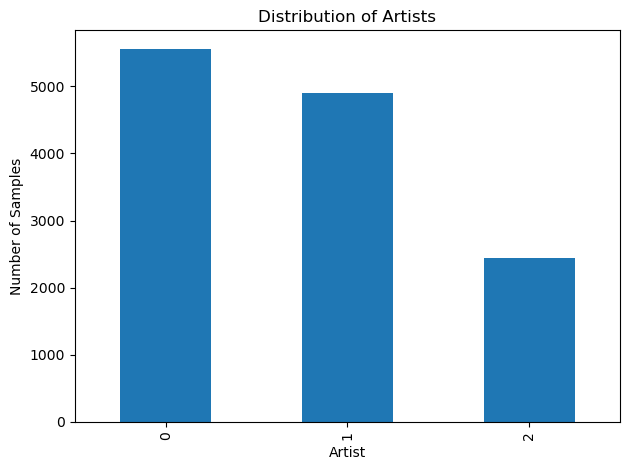

In [7]:
plt.figure()
df["artist"].value_counts().plot(kind="bar")
plt.xlabel("Artist")
plt.ylabel("Number of Samples")
plt.title("Distribution of Artists")
plt.tight_layout()
plt.show()

In [8]:
parts_per_mini = df.groupby("mini").size()

avg_parts = parts_per_mini.mean()
max_parts = parts_per_mini.max()
min_parts = parts_per_mini.min()

print("Average parts per mini:", avg_parts)
print("Max parts for a mini:", max_parts)
print("Min parts for a mini:", min_parts)

Average parts per mini: 5.498293515358362
Max parts for a mini: 61
Min parts for a mini: 1


In [9]:
def is_nan_columns(df):
    nan_rows = None
    if df.isnull().values.any():
        print("Dataset contains NaN values.")
    
        nan_counts = df.isnull().sum()
        print("NaN counts in each column:")
        print(nan_counts[nan_counts > 0])

        print()
        
        nan_rows = df[df.isnull().any(axis=1)]

    return nan_rows

df_nans = is_nan_columns(df)

Dataset contains NaN values.
NaN counts in each column:
weight        1
base_mm    1286
dtype: int64



In [10]:
df.dropna(subset=['weight'], inplace=True)

In [11]:
def preprocess_df(df, features_to_keep, label):
    df['kb']       = df['kb'].astype(int)
    df['volume']   = np.ceil(df['volume'] * 10) / 10

    # Polynomial Features
    df['volume_g'] = df['volume'] * 1e-3 * 1.1
    df['mass_g'] = df['mass']  * 1e-3 * 1.1
    
    # Interaction Features
    df['volume_mass_interaction'] = df['volume_g'] * df['mass_g']
    df['surface_volume_ratio'] = df['surface_area'] / df['volume']
    df['bbox_volume_ratio'] = df['bbox_area'] / df['volume']
    
    # Dimension Ratios
    df['surface_mass_ratio'] = df['surface_area'] / df['mass']
    df['bbox_mass_ratio'] = df['bbox_area'] / df['mass']

    for col in ['surface_area', 'bbox_x', 'bbox_y', 'bbox_z', 'bbox_area', 'weight', 'scale',
                'volume', 'volume_g', 'mass', 'mass_g', 'volume_mass_interaction', 'surface_volume_ratio', 'surface_mass_ratio']:
        df[col] = df[col].round(1)

    df = df[[*features_to_keep, label]]

    return df

features = [
    'volume',
    'mass',
    'volume_mass_interaction',
    'surface_volume_ratio',
    'surface_mass_ratio'
]

label = 'weight'

df = preprocess_df(df, features, label)

In [12]:
df.head()

,volume,mass,volume_mass_interaction,surface_volume_ratio,surface_mass_ratio,weight
0,26671.5,26671.5,860.8,2.4,2.4,26.9
1,279.4,279.4,0.1,3.7,3.7,0.2
2,12494.2,12494.2,188.9,2.2,2.2,11.7
3,6960.5,6960.4,58.6,3.2,3.2,6.2
4,3515.4,3515.4,15.0,2.4,2.4,3.6


In [13]:
def plot_feature_distribution_with_bounds(df, feature, q1=0.25, q3=0.85, factor=1.5, bins=100, artist=None):
    col = df[feature]
    Q1 = col.quantile(q1)
    Q3 = col.quantile(q3)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR

    plt.figure()
    plt.hist(col, bins=bins)
    plt.axvline(upper_bound, linestyle="--")
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.title(f"{feature} distribution with IQR bounds - Artist: {artist}")
    plt.tight_layout()
    plt.show()

    print(f"{feature} Q1={Q1:.3f}, Q3={Q3:.3f}, IQR={IQR:.3f}")
    print(f"Upper Bound:{upper_bound:.3f}")

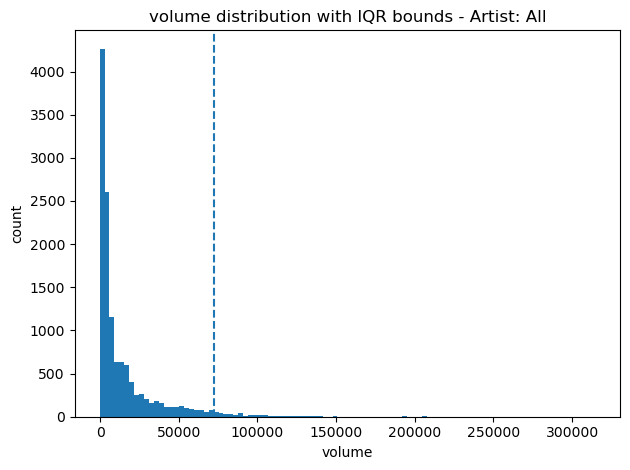

volume Q1=1710.900, Q3=29866.670, IQR=28155.770
Upper Bound:72100.325


In [14]:
plot_feature_distribution_with_bounds(df, feature='volume', artist='All')

In [16]:
def remove_outliers(df, features, q1=0.25, q3=0.85, factor=1.5):
    if isinstance(features, str):
        features = [features]

    cols = df[features]

    Q1 = cols.quantile(q1)
    Q3 = cols.quantile(q3)
    IQR = Q3 - Q1

    upper_bounds = Q3 + factor * IQR

    outlier_flags = cols > upper_bounds
    row_outlier = outlier_flags.any(axis=1)

    mask = ~row_outlier

    print("Upper bounds:")
    print(upper_bounds)
    print(f"→ keeping {mask.sum()} / {len(df)} rows")

    return df[mask]

df = remove_outliers(df, features=['volume'])

Upper bounds:
volume    72100.325
dtype: float64
→ keeping 12479 / 12887 rows


In [17]:
def split_dataset(df, target, test_size, seed, stratified=False, stratified_column=None, num_bins=4):
    tmp = df.copy()

    if stratified and stratified_column:
        tmp["stratified_bins"] = pd.qcut(
            tmp[stratified_column],
            q=num_bins,
            duplicates="drop"
        )
        stratify_col = tmp["stratified_bins"]
    else:
        stratify_col = None

    X = tmp.drop(columns=[target])
    y = tmp[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=seed,
        stratify=stratify_col
    )

    if stratified and stratified_column:
        X_train = X_train.drop(columns=["stratified_bins"])
        X_test = X_test.drop(columns=["stratified_bins"])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(df, 'weight', 0.2, SEED, stratified=True, stratified_column='volume')
X_train = np.array(X_train, dtype=np.float32)

In [18]:
def build_and_compile_model(hp, n_features, normalizer):
    model = Sequential()

    model.add(Input(shape=(n_features,)))
    model.add(normalizer)

    init_units = hp.Int('init_units', min_value=32, max_value=1024, step=32)

    regularizer = hp.Choice('regularizer', values=['none', 'l1', 'l2', 'both'])
    l1_str = hp.Float('l1_str', min_value=1e-6, max_value=1e-2, sampling='log')
    l2_str = hp.Float('l2_str', min_value=1e-6, max_value=1e-2, sampling='log')

    tested_activations = ['relu', 'leaky_relu', 'elu', 'tanh', 'selu', 'linear', 'swish', 'mish']
    
    if regularizer == 'none':
        kernel_regularizer = None
    elif regularizer == 'l1':
        kernel_regularizer = l1(l1_str)
    elif regularizer == 'l2':
        kernel_regularizer = l2(l2_str)
    else:
        kernel_regularizer = l1_l2(l1=l1_str, l2=l2_str)
    
    model.add(Dense(init_units, kernel_regularizer=kernel_regularizer))
    model.add(Activation(hp.Choice('init_activation', values=tested_activations)))

    if hp.Choice('init_batch_normalization', values=[True, False]):
        model.add(BatchNormalization())

    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=8, step=1)
    num_units = [
        hp.Int(f'units_{i}', min_value=32, max_value=1024, step=32)
        for i in range(num_dense_layers)
    ]

    for i in range(num_dense_layers):
        normalization = hp.Choice(f'batch_normalization_{i}', values=[True, False])
        normalization_location = hp.Choice(
            f'batch_normalization_position_{i}', values=['before', 'after']
        )
        
        model.add(Dense(num_units[i], kernel_regularizer=kernel_regularizer))

        if normalization and normalization_location == 'before':
            model.add(BatchNormalization())
        
        model.add(Activation(hp.Choice(f'activation_{i}', values=tested_activations)))

        if normalization and normalization_location == 'after':
            model.add(BatchNormalization())

        dropout_units = hp.Float(
            f'dropout_{i}', min_value=0.0, max_value=0.75, step=0.05
        )

        if dropout_units > 0:
            model.add(Dropout(dropout_units))

    model.add(Dense(1))

    opt_name = hp.Choice('optimizer', values=['adam', 'adamw', 'nadam', 'adamax', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')

    if opt_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif opt_name == 'adamw':
        optimizer = AdamW(learning_rate=learning_rate)
    elif opt_name == 'nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif opt_name == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    elif opt_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[MeanAbsoluteError()])
    
    return model

def search_best_model(project_name, x, y, seed, epochs=50, max_trials=10, split=0.2, batch_size=None, show_model=True):
    n_features = x.shape[1]

    normalizer = Normalization(axis=-1)
    normalizer.adapt(x)

    tuner = kt.BayesianOptimization(
        lambda hp: build_and_compile_model(hp, n_features, normalizer),
        objective=kt.Objective("val_mean_absolute_error", direction="min"),
        max_trials=max_trials,
        directory='bayesian_optimization',
        project_name=project_name,
        seed=seed
    )

    tuner.search(
        x, y,
        epochs=epochs,
        validation_split=split,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.01, patience=10,
                          verbose=0, mode='min', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=5,
                              min_lr=1e-8, mode='min', verbose=0)
        ]
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model_from_tuner = tuner.hypermodel.build(best_hps)

    if show_model:
        print("Best Model from Tuner:")
        best_model_from_tuner.summary()

    return best_hps, best_model_from_tuner

def show_best_hps(hps):
    print("Best Hyperparameters:")
    for hp in hps.values:
        print(f"{hp}: {hps.get(hp)}")

In [ ]:
best_hps, best_model = search_best_model('All_Artists', X_train, y_train, epochs=EPOCHS, max_trials=MAX_TRIALS, seed=SEED, batch_size=BATCH_SIZE)
show_best_hps(best_hps)

Trial 33 Complete [00h 00m 08s]
val_mean_absolute_error: nan

Best val_mean_absolute_error So Far: 0.511026918888092
Total elapsed time: 00h 10m 46s

Search: Running Trial #34

Value             |Best Value So Far |Hyperparameter
128               |416               |init_units
both              |l2                |regularizer
0.0093469         |2.1713e-05        |l1_str
0.00014276        |0.00071184        |l2_str
relu              |relu              |init_activation
1                 |0                 |init_batch_normalization
7                 |1                 |num_dense_layers
544               |320               |units_0
1                 |0                 |batch_normalization_0
before            |after             |batch_normalization_position_0
selu              |mish              |activation_0
0.65              |0.3               |dropout_0
adamw             |adamax            |optimizer
0.007637          |0.0069261         |learning_rate
320               |576             

In [ ]:
%%time

history = best_model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.01, patience=10, mode='min', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=5, min_lr=1e-8, mode='min')
    ]
)

In [ ]:
def plot_loss(history, artist=None):
    plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
    plt.ylim([0, 10])
    plt.title(f"Artist: {artist}")
    plt.xlabel('Epoch')
    plt.ylabel('Error [MAE]')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history, 'All')

In [ ]:
print('Best All_Artists Model: ', best_model.evaluate(X_test, y_test, verbose=0))

In [ ]:
predictions = best_model.predict(X_test).flatten()

In [ ]:
def plot_residuals(y, predictions, error_margin, artist=None):
    residuals = y - predictions.flatten()
    
    plt.figure(figsize=(10, 6))

    plt.axhline(y=error_margin, color='lightgrey', linestyle='--', alpha=0.8, label=f'+/- {error_margin} error margin')
    plt.axhline(y=-error_margin, color='lightgrey', linestyle='--', alpha=0.8)
    
    plt.scatter(predictions, residuals, alpha=0.5, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
    
    plt.ylim(min(residuals.min(), -error_margin * 1.1), max(residuals.max(), error_margin * 1.1))
    
    plt.title(f'Residuals vs. Predicted Values - Artist: {artist}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

plot_residuals(y_test, predictions, ERROR_MARGIN_G, artist='All')

In [ ]:
def plot_error_margin(y, predictions, error_margin, artist=None):
    residuals = np.abs(y - predictions)
    accurate_predictions = residuals <= error_margin
    underestimations = (y - predictions) > error_margin
    overestimations = (predictions - y) > error_margin
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions[accurate_predictions], y[accurate_predictions], color='green', alpha=0.5, label=f'Accurate within {error_margin} grams')
    plt.scatter(predictions[underestimations], y[underestimations], color='blue', alpha=0.5, label='Underestimations')
    plt.scatter(predictions[overestimations], y[overestimations], color='red', alpha=0.5, label='Overestimations')
    
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Prediction Accuracy with {error_margin} Grams Error Margin - Artist: {artist}')
    plt.legend()
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.show()

plot_error_margin(y_test, predictions, ERROR_MARGIN_G, artist='All')

In [ ]:
def plot_error_distribution(y_true, y_pred, artist=None):
    differences = y_pred - y_true

    boundaries = [(-np.inf, -15), (-15, -10), (-10, -5), (-5, -4), (-4, -3), (-3, -2), (-2, -1), (-1, 1),
                  (1, 2), (2, 3), (3, 4), (4, 5), (5, 10), (10, 15), (15, np.inf)]
    labels = ['<-15', '-15 to -10', '-10 to -5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', 
              'Within +/- 1', 
              '1 to 2', '2 to 3', '3 to 4', '4 to 5', '5 to 10', '10 to 15', '>15']
    
    counts = np.zeros(len(labels))
    
    for i, (lower, upper) in enumerate(boundaries):
        if i == 7:  # Special case for 'Within +/- 1'
            counts[i] = np.sum((differences >= lower) & (differences < upper))
        else:
            counts[i] = np.sum((differences > lower) & (differences <= upper))
    
    non_zero_counts = counts > 0
    filtered_labels = np.array(labels)[non_zero_counts]
    filtered_counts = counts[non_zero_counts]

    plt.figure(figsize=(14, 8))
    plt.bar(filtered_labels, filtered_counts, color='skyblue')
    plt.xlabel('Error Range (grams)')
    plt.ylabel('Count')
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

plot_error_distribution(y_test, predictions, artist='All')

In [ ]:
df_comparison = pd.DataFrame({'y_test':y_test, 'y_pred': predictions})

In [ ]:
def get_results(model_name, predictions, y, error_margin=2, num_predictors=None):
    if num_predictors is None:
        raise ValueError("num_predictors must be provided to calculate adjusted R-squared.")
    
    n = len(y)
    p = num_predictors
    
    absolute_diff = np.abs(predictions - y)
    correct_predictions = np.sum(absolute_diff <= error_margin) / n * 100
    
    rmse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r_squared = r2_score(y, predictions)
    adjusted_r_squared = 1 - (1-r_squared) * (n-1) / (n-p-1)

    print(f'++++++++ Results for model {model_name} ++++++++\n')
    print(f"Percentage of predictions within {error_margin} grams of the actual values: {correct_predictions}%")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R-squared: {r_squared}")
    print(f"Adjusted R-squared: {adjusted_r_squared}")

    return correct_predictions

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        results = self.model.evaluate(X, y, verbose=0)
        # Assuming the first element is the loss
        loss = results[0]
        return -loss

def plot_permutation_importance(model, X_test, y_test, seed, artist=None):
    wrapped_model = KerasRegressorWrapper(model)
    result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=1)
    
    sorted_idx = result.importances_mean.argsort()
    plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
    plt.title(f'Prediction Error Distribution - Artist: {artist}')
    plt.xlabel("Permutation Importance")
    plt.show()

def calculate_differences(y_test, y_pred):
    differences = y_pred - y_test
    
    avg_difference = np.mean(np.abs(differences))
    min_difference = np.min(differences)
    max_difference = np.max(differences)
    
    print(f'Average difference: {avg_difference}, Minimum difference: {min_difference}, Maximum difference: {max_difference}')

def save_model(model, file_path, accuracy):
    if accuracy > 80 and not os.path.exists(file_path):
        model.save(file_path)
        print(f'Model saved as {file_path}')

In [ ]:
accuracy = get_results('All_Artist', predictions, y_test, error_margin=ERROR_MARGIN_G, num_predictors=best_model.input_shape[1])
calculate_differences(y_test, predictions)
save_model(best_model, f'model_all-{round(accuracy, 3)}.keras', accuracy)
plot_permutation_importance(best_model, X_test, y_test, SEED, artist='All')